In [1]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display,IFrame,HTML,Image
import itertools
from matplotlib.colors import ListedColormap
from z3 import *

### Puzzle as published 
https://www.janestreet.com/puzzles/choco-banana-index/

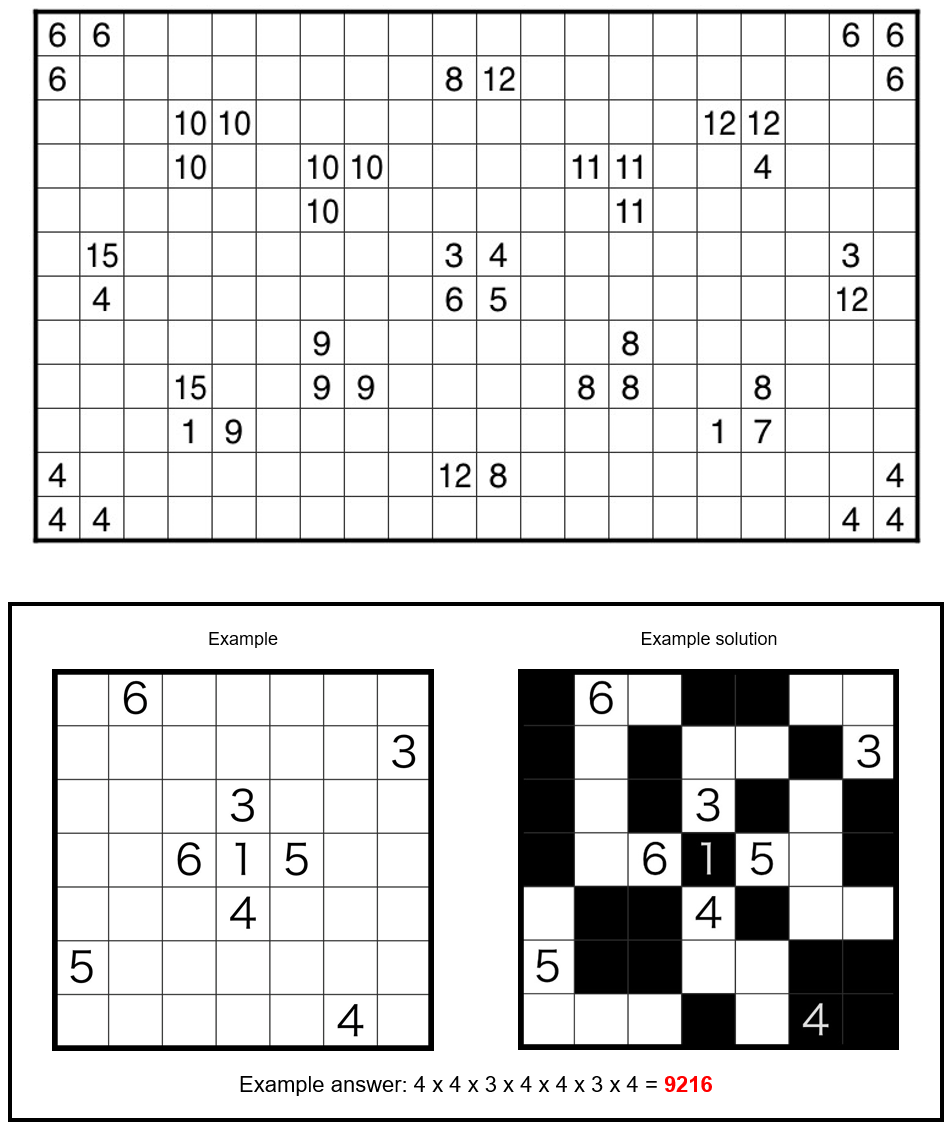

### Choco Banana

Show Solution
If we shade a subset of the cells in the above grid, we partition the
cells into orthogonally connected
regions
of shaded and unshaded
cells. The goal of this puzzle is to shade the cells so that
all regions of shaded cells are rectangular,
all regions of unshaded cells are
not
rectangular, and
all number clues in the grid give the size of the region (shaded or
unshaded) that the clue is in.
The answer to this puzzle is the product of the number of unshaded
cells in each row.

In [2]:
url='https://www.janestreet.com/puzzles/choco-banana-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+url))
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Image('https://www.janestreet.com/puzzles/choco-banana.png',width=400))
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[10:20]))))

In [3]:
def neigh(x,y,N):
    return [(i+x,j+y) for i,j in [(-1,0),(0,-1),(1,0),(0,1)] if i+x >=0 and i+x <N[0] and j+y >=0 and j+y <N[1]]

def pr(ans,fix,edge):
    n = fix.shape
    colours = ['palegreen','k']
    annot = fix.astype('str')
    annot[annot=="0"] =""
    fig,ax = plt.subplots(1,1,figsize=(n[1]*0.375,n[0]*0.375))
    ax =sns.heatmap(ans,annot=annot,cbar=False,cmap=ListedColormap(colours),fmt="",linewidths=1,annot_kws={"size":14},linecolor='grey')
    ax.axis("off")
    plt.tight_layout()
    plt.show()


In [4]:
def sol(grid,soln,M=17):
    start = time.time()
    N = grid.shape

    #set up the solver and variables.
    s = Tactic("qffd").solver()

    # set up numbers
    X = np.array(IntVector("x",np.product(N)),dtype=object).reshape(*N)
    Y = np.array(IntVector("y",np.product(N)),dtype=object).reshape(*N)
    root = np.array(IntVector('root', np.product(N)),dtype=object).reshape(*N)
    order = np.array(IntVector('order', np.product(N)),dtype=object).reshape(*N)

    # constrain
    s += [And(e>=0,e<M) for (i,j),e in np.ndenumerate(X)]
    s += [And(e>=0,e<=1) for (i,j),e in np.ndenumerate(Y)]
    s += [And(e>=0,e<=1) for (i,j),e in np.ndenumerate(root)]
    s += [And(e>= 0 ,e <=int(np.max(grid))) for (i,j),e in np.ndenumerate(order)]

    #touching regions have different shading
    s+=[And([Not(Xor(X[i,j]==X[k,l],Y[i,j]==Y[k,l])) for (k,l) in neigh(i,j,N)]) for (i,j),e in np.ndenumerate(X)]
    s+=[And([Not(Xor(X[i,j]!=X[k,l],Y[i,j]!=Y[k,l])) for (k,l) in neigh(i,j,N)]) for (i,j),e in np.ndenumerate(X)]

    for m in range(M):
        #one root per region
        s+= PbLe([(And(e==m,root[i,j]==1),1) for (i,j),e in np.ndenumerate(X)],1)
        count = Sum([If(e==m,1,0) for _,e in np.ndenumerate(X)])
        #size of region = number
        for i in range(N[0]):
            for j in range(N[1]):
                if grid[i,j]>0:
                    s+= Implies(X[i,j]==m, count==int(grid[i,j]))

    edge ={}
    # create edges and variable to define order in connectivity tree
    for i in range(N[0]):
        for j in range(N[1]):
            s+= Implies(int(grid[i,j])==1,Y[i,j]==1)
            for (k,l) in neigh(i,j,N):
                edge[(i,j,k,l)] = Int("e%d%d%d%d" % (i,j,k,l))
                s+=And(edge[(i,j,k,l)] >=0,edge[(i,j,k,l)] <=1)

    for i in range(N[0]):
        for j in range(N[1]):  
            for (k,l) in neigh(i,j,N):
                s += Or(edge[(i,j,k,l)] ==0,edge[(k,l,i,j)]==0)
                s+=[Implies(Or(edge[(i,j,k,l)] ==1,edge[(k,l,i,j)]==1),X[i,j]==X[k,l]) for (k,l) in neigh(i,j,N)]
                s+=[Implies(edge[(k,l,i,j)]==1,order[i,j]+1 ==order[k,l]) for (k,l) in neigh(i,j,N)]

            total_in = lambda i,j:Sum([If(edge[(k,l,i,j)]==1,1,0) for (k,l) in neigh(i,j,N)])

            s+=Implies(root[i,j]!=1,total_in(i,j)>=1)
            
    #rectangle constraints
    top_row = IntVector('top_row',M)
    bot_row = IntVector('bot_row',M)
    lft_col = IntVector('lft_col',M)
    rgt_col = IntVector('rgt_col',M)

    s += [And(e>=0,e<N[0]) for e in top_row + bot_row]
    s += [And(e>=0,e<N[1]) for e in lft_col + rgt_col]

    for m in range(M):
        s+= top_row[m]>=bot_row[m]
        s+= rgt_col[m]>=lft_col[m]
        tot = Sum([If(e==m,Y[i,j],0) for (i,j),e in np.ndenumerate(X)])
        s += And([Implies(Or(i<bot_row[m],i>top_row[m],j<lft_col[m],j>rgt_col[m]),X[i,j]!=m) for (i,j),e in np.ndenumerate(X)])
        s += Implies(tot > 0, And([Implies(And(i>=bot_row[m],i<=top_row[m],j>=lft_col[m],j<=rgt_col[m]),X[i,j]==m) for (i,j),e in np.ndenumerate(X)]))
        s += Implies(tot ==0, Or([Implies(Or(i>=bot_row[m],i<=top_row[m],j>=lft_col[m],j<=rgt_col[m]),X[i,j]!=m) for (i,j),e in np.ndenumerate(X)]))

    s += [X[i,j]==int(e) for (i,j),e in np.ndenumerate(soln[:,:]) if e !=0]

    print("setup done in {:.2f} secs".format(time.time()-start))
    if s.check() == sat:
        m = s.model()
        evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
        result_x =  evalu(X)
        result_y =  evalu(Y)
        pr(result_y,grid,[i for i in edge if evalu(edge[i])==1 ])   
        print("Solution is {:,.0f} done in {:.2f} secs".format(np.product(np.sum(result_y==0,axis=1),dtype=np.int64),time.time()-start))
    else:
        print("fail")

setup done in 1.68 secs


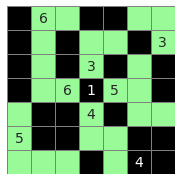

Solution is 9,216 done in 196.37 secs


In [5]:
grid =np.array([[0,6,0,0,0,0,0],
                 [0,0,0,0,0,0,3],
                 [0,0,0,3,0,0,0],
                 [0,0,6,1,5,0,0],
                 [0,0,0,4,0,0,0],
                 [5,0,0,0,0,0,0],
                 [0,0,0,0,0,4,0]])

soln =np.array([[ 0, 1, 1, 2, 2, 3, 3],
                 [ 0, 1, 4, 5, 5, 6, 3],
                 [ 0, 1, 4, 5, 7, 8, 9],
                 [ 0, 1, 1,10, 8, 8, 9],
                 [11,12,12,13,14, 8, 8],
                 [11,12,12,13,13,15,15],
                 [11,11,11,16,13,15,15]])

sol(grid,np.zeros_like(grid),17)
#sol(grid,soln,17)

setup done in 18.77 secs


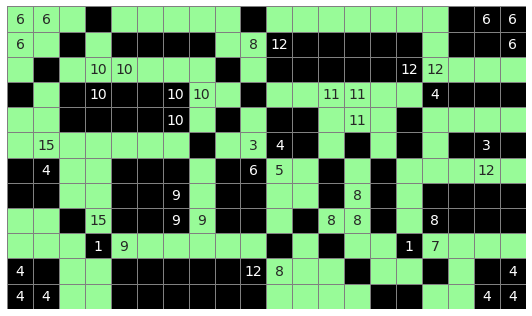

Solution is 809,321,103,360 done in 20.68 secs


In [5]:
grid = np.array([[6,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6],
                 [6,  0,  0,  0,  0,  0,  0,  0,  0,  8, 12,  0,  0,  0,  0,  0,  0,  0,  0,  6],
                 [0,  0,  0, 10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12, 12,  0,  0,  0],
                 [0,  0,  0, 10,  0,  0, 10, 10,  0,  0,  0,  0, 11, 11,  0,  0,  4,  0,  0,  0],
                 [0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0],
                 [0, 15,  0,  0,  0,  0,  0,  0,  0,  3,  4,  0,  0,  0,  0,  0,  0,  0,  3,  0],
                 [0,  4,  0,  0,  0,  0,  0,  0,  0,  6,  5,  0,  0,  0,  0,  0,  0,  0, 12,  0],
                 [0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0],
                 [0,  0,  0, 15,  0,  0,  9,  9,  0,  0,  0,  0,  8,  8,  0,  0,  8,  0,  0,  0],
                 [0,  0,  0,  1,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  7,  0,  0,  0],
                 [4,  0,  0,  0,  0,  0,  0,  0,  0, 12,  8,  0,  0,  0,  0,  0,  0,  0,  0,  4],
                 [4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  4],
])

soln = np.array([[ 1,  1,  1, 15,  2,  2,  2,  2,  2, 16,  3,  3,  3,  3,  3,  3, 3, 17, 17, 17],
       [ 1,  1, 18,  4, 19, 19, 19, 19,  2,  2, 20, 20, 20, 20, 20, 20, 3, 17, 17, 17],
       [ 1, 21,  4,  4,  4,  4,  4,  4, 22,  2, 20, 20, 20, 20, 20, 20, 3,  3,  3,  3],
       [23,  5, 24, 24, 24, 24, 24,  4,  4, 25,  6,  6,  6,  6,  6,  6, 26, 26, 26, 26],
       [ 5,  5, 24, 24, 24, 24, 24,  4, 27,  7, 28, 28,  6,  6,  6, 29, 8,  8,  8,  8],
       [ 5,  5,  5,  5,  5,  5,  5, 30,  7,  7, 28, 28,  6, 31,  6, 29, 8, 32, 32, 32],
       [33, 33,  5,  5, 34, 34, 34,  9, 35, 35, 10, 10, 36, 11, 37,  8, 8,  8,  8,  8],
       [33, 33,  5,  5, 34, 34, 34,  9, 35, 35, 10, 10, 36, 11, 37,  8,38, 38, 38, 38],
       [12, 12, 39,  5, 34, 34, 34,  9, 35, 35, 10, 40, 11, 11, 37,  8,38, 38, 38, 38],
       [12, 12, 12, 41,  9,  9,  9,  9,  9,  9, 42, 13, 43, 11, 11, 44,14, 14, 14, 14],
       [45, 45, 12, 12, 46, 46, 46, 46, 46, 46, 13, 13, 13, 47, 11, 11,48, 14, 49, 49],
       [45, 45, 12, 12, 46, 46, 46, 46, 46, 46, 13, 13, 13, 13, 50, 50,14, 14, 49, 49]])

#sol(grid,np.zeros_like(grid),51)
sol(grid,soln,51)

### Solution as published 
https://www.janestreet.com/puzzles/choco-banana-solution/

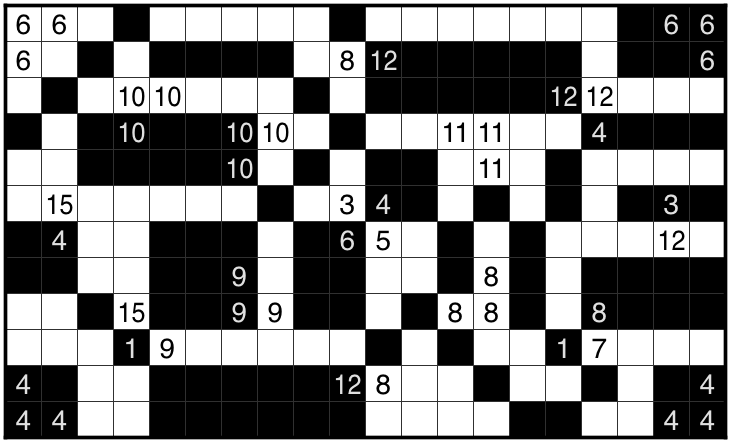

### Choco Banana

The above image shows the shaded regions that satisfy the
requirements. The rows have unshaded cell counts 15, 6, 12, 9, 11, 12,
11, 7, 8, 16, 8, and 8 which multiply to
809321103360
.
Congrats to this month’s solvers who successfully completed the puzzle!

In [9]:
url='https://www.janestreet.com/puzzles/choco-banana-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Solution as published \n'+url))
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Image('https://www.janestreet.com/puzzles/choco-banana-solution.png',width=400))
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[11:15]))))